# Jupyter notebook for debugging

In [1]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

In [2]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_nuscenes.yaml'
data = 'data/nuscenes.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

Overriding model.yaml nc=4 with nc=15

                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  6                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]             

In [3]:
anchors = model.model[-1].anchors
# [TODO] Draw anchors

In [4]:
anchors_num = anchors.numpy()

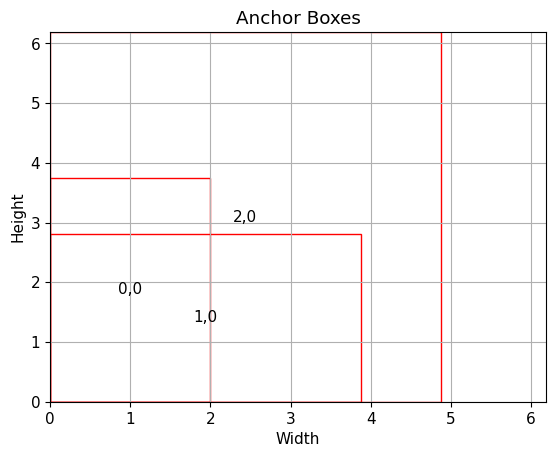

In [5]:
# [TODO] Draw anchors
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# img = np.ones((416,416))*255
# image_shape = [416, 416]

fig, ax = plt.subplots(1)
# ax.imshow(img, extent=[0, image_shape[1], image_shape[0], 0], cmap='gray')
for i, anchor in enumerate(anchors_num):
    for j in range(anchor.shape[0]):
        rect = plt.Rectangle((0, 0), anchor[j][0], anchor[j][1], edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(anchor[j][0]/2, anchor[j][1]/2, f'{i},{j}', ha='center', va='center')

plt.xlim([0, max(anchors[:, :, 0].max(), anchors[:, :, 1].max())])
plt.ylim([0, max(anchors[:, :, 0].max(), anchors[:, :, 1].max())])
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Anchor Boxes')
plt.grid(True)
plt.show()


In [6]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 416
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
test_path = data_dict["test"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=True,
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=True,
    seed=seed,
)

test_loader, test_dataset = create_dataloader(
    test_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("test: "),
    shuffle=False,
    seed=seed,
)

train: Scanning /home/hyu3/Choi/nuscenes_det2d/train.cache... 28130 images, 1425 backgrounds, 0 corrupt: 100%|██████████| 28130/28130 [00:00<?, ?it/s]
test: Scanning /home/hyu3/Choi/nuscenes_det2d/test... 0 images, 6008 backgrounds, 0 corrupt: 100%|██████████| 6008/6008 [00:00<00:00, 7791.24it/s] 
test: WARNING ⚠️ No labels found in /home/hyu3/Choi/nuscenes_det2d/test.cache. See https://docs.ultralytics.com/yolov5/tutorials/train_custom_data
test: New cache created: /home/hyu3/Choi/nuscenes_det2d/test.cache


In [13]:
for imgs, targets, paths, _ in train_loader:
    imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0
    break

In [34]:
import torch
from models.common import DetectMultiBackend
from utils.torch_utils import select_device

weights = 'runs/train/yolov5n2/weights/best.pt'
data = 'data/nuscenes.yaml'
# data = 'data/coco128.yaml'
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)

# inference
model.eval()
with torch.no_grad():
    pred = model(imgs)  # forward

YOLOv5 🚀 ddf4e91 Python-3.9.19 torch-2.2.1+cu118 CPU

Fusing layers... 
YOLOv5n_nuscenes summary: 157 layers, 1761420 parameters, 0 gradients, 4.1 GFLOPs


In [8]:
for imgs, targets, paths, _ in test_loader:
    test_imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0
    break

model.eval()
with torch.no_grad():
    pred1 = model(test_imgs)

In [9]:
from utils.general import non_max_suppression

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

pred = non_max_suppression(pred1, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# [TODO] draw predictions (see detect.py:L178)


In [11]:
import numpy as np
import torch

def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):

    if ratio_pad is None: 
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[..., [0, 2]] -= pad[0]  
    coords[..., [1, 3]] -= pad[1]  
    coords[..., :4] /= gain
    clip_coords(coords, img0_shape)
    return coords

def clip_coords(boxes, shape):

    if isinstance(boxes, torch.Tensor):
        boxes[:, 0].clamp_(0, shape[1])  
        boxes[:, 1].clamp_(0, shape[0])  
        boxes[:, 2].clamp_(0, shape[1])  
        boxes[:, 3].clamp_(0, shape[0])  
    else:  
        boxes[:, 0] = np.clip(boxes[:, 0], 0, shape[1])  
        boxes[:, 1] = np.clip(boxes[:, 1], 0, shape[0])  
        boxes[:, 2] = np.clip(boxes[:, 2], 0, shape[1])  
        boxes[:, 3] = np.clip(boxes[:, 3], 0, shape[0]) 


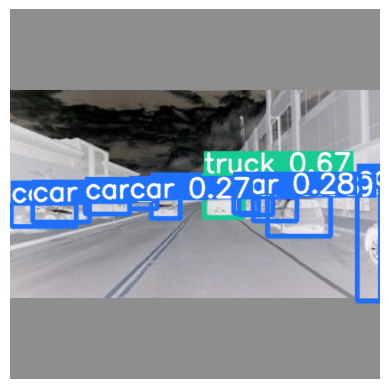

In [15]:
import numpy as np
from ultralytics.utils.plotting import Annotator, colors

# Draw predictions
names = model.names if hasattr(model, 'names') else model.module.names
for i, det in enumerate(pred):  # per image
    im0 = imgs[i].cpu().numpy().transpose(1, 2, 0) * 255  # convert to numpy array
    im0 = im0.astype(np.uint8)
    im0 = np.ascontiguousarray(im0)  
    annotator = Annotator(im0, line_width=3, example=str(names))
    if len(det):
        det[:, :4] = scale_coords(imgs[i].shape[1:], det[:, :4], im0.shape).round()
        for *xyxy, conf, cls in det:
            label = f'{names[int(cls)]} {conf:.2f}'
            annotator.box_label(xyxy, label, color=colors(int(cls), True))

    # Show image
    plt.imshow(im0)
    plt.axis('off')
    plt.show()